In [7]:
import os
import pickle
import subprocess

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import open3d as o3d

from src.base_src.coloradar_tools import ColoradarDataset, RadarParameters, CascadeRadarParameters, get_heatmap, filter_cloud, show_pcl_prob, show_radar_pointcloud

### Sensor Parameters

#### Lidar
- 0.01◦ angular accuracy
- angular resolution 0.35◦ horizontal
- 0.7◦ vertical
- 3cm range accuracy
- field of view 360◦ horizontal
- 45◦ vertical
- max range 120m

#### Single Chip Radar
- Range resolution 0.125m
- Max range 12m
- Doppler velocity resolution 0.04 m/s
- Max Doppler velocity 2.56 m/s
- Azimuth resolution 11.3◦
- Elevation resolution 45◦

#### Cascade Radar
- Range resolution 0.117m
- Max range 15m
- Doppler velocity resolution 0.254 m/s
- Max Doppler velocity 2.02 m/s
- Azimuth resolution 1.05◦
- Elevation resolution 22.5◦

### Set Dataset Path

In [8]:
COLORADAR_PATH = os.path.join(os.path.expanduser('~'), 'coloradar')
dataset = ColoradarDataset(COLORADAR_PATH)

In [9]:
run_name = dataset.list_runs()[0]
dataset.list_runs()

['ec_hallways_run0', 'longboard_run0', 'edgar_classroom_run0']

In [16]:
show_radar_pointcloud(os.path.join(COLORADAR_PATH, 'kitti', run_name, 'cascade', 'pointclouds', 'data', 'radar_pointcloud_0.bin'))

### Test Pose Interpolation

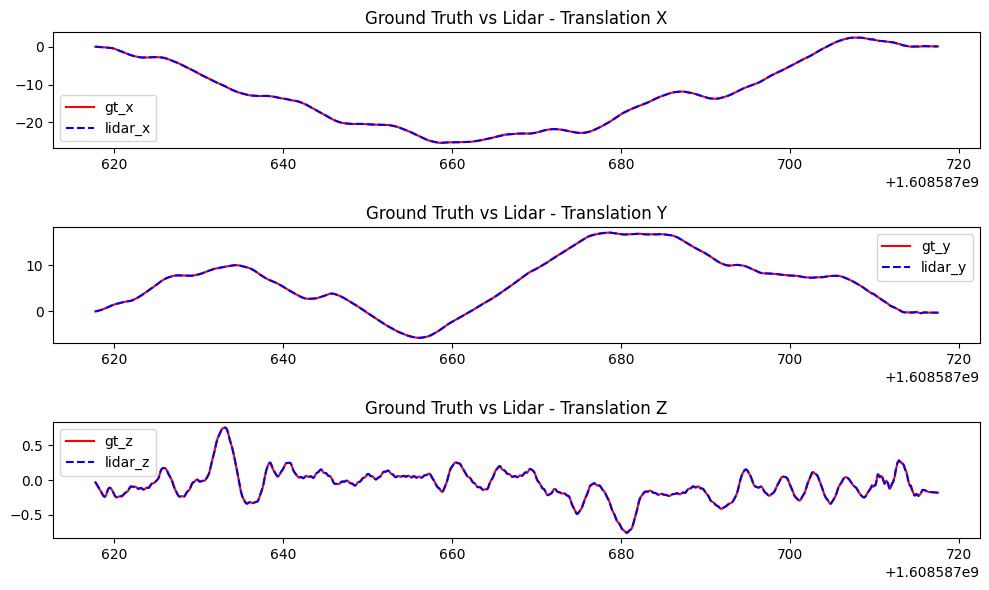

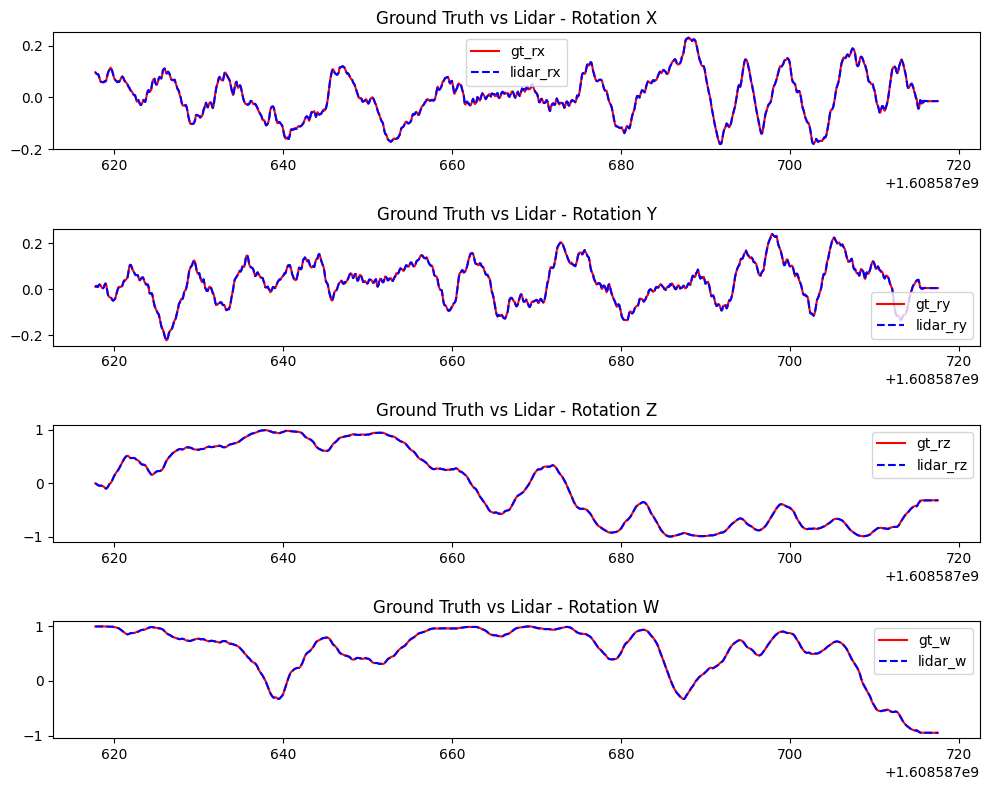

In [4]:
dataset.show_poses(run_name)

### Build Lidar Octomap

In [6]:
for run_name in dataset.list_runs():
    dataset.build_octomap(run_name=run_name, map_resolution=0.25, horizontal_fov=360, vertical_fov=33.2, max_range=40)

Building map for ec_hallways_run0 ...


In [7]:
dataset.show_octomap_prob('ec_hallways_run0', prob_threshold=0)

In [5]:
dataset.show_octomap_prob('ec_hallways_run0', prob_threshold=0.65)

#### Try Filtering

In [4]:
filter_cloud(os.path.join(COLORADAR_PATH, 'kitti', 'ec_hallways_run0', 'lidar_maps', 'map.pcd'), horizontal_fov=360, vertical_fov=180, max_range=20)

In [4]:
show_pcl_prob(os.path.join(COLORADAR_PATH, 'kitti', 'ec_hallways_run0', 'lidar_maps', 'original_cloud.pcd'))

In [5]:
show_pcl_prob(os.path.join(COLORADAR_PATH, 'kitti', 'ec_hallways_run0', 'lidar_maps', 'filtered_cloud.pcd'))

In [7]:
show_pcl_prob(os.path.join(COLORADAR_PATH, 'kitti', 'ec_hallways_run0', 'lidar_maps', 'filtered_cloud.pcd'), prob_threshold=0.65)

### Show Single Chip Radar FOV Options

In [6]:
radar_params = RadarParameters(COLORADAR_PATH)
radar_params.max_range

8.0

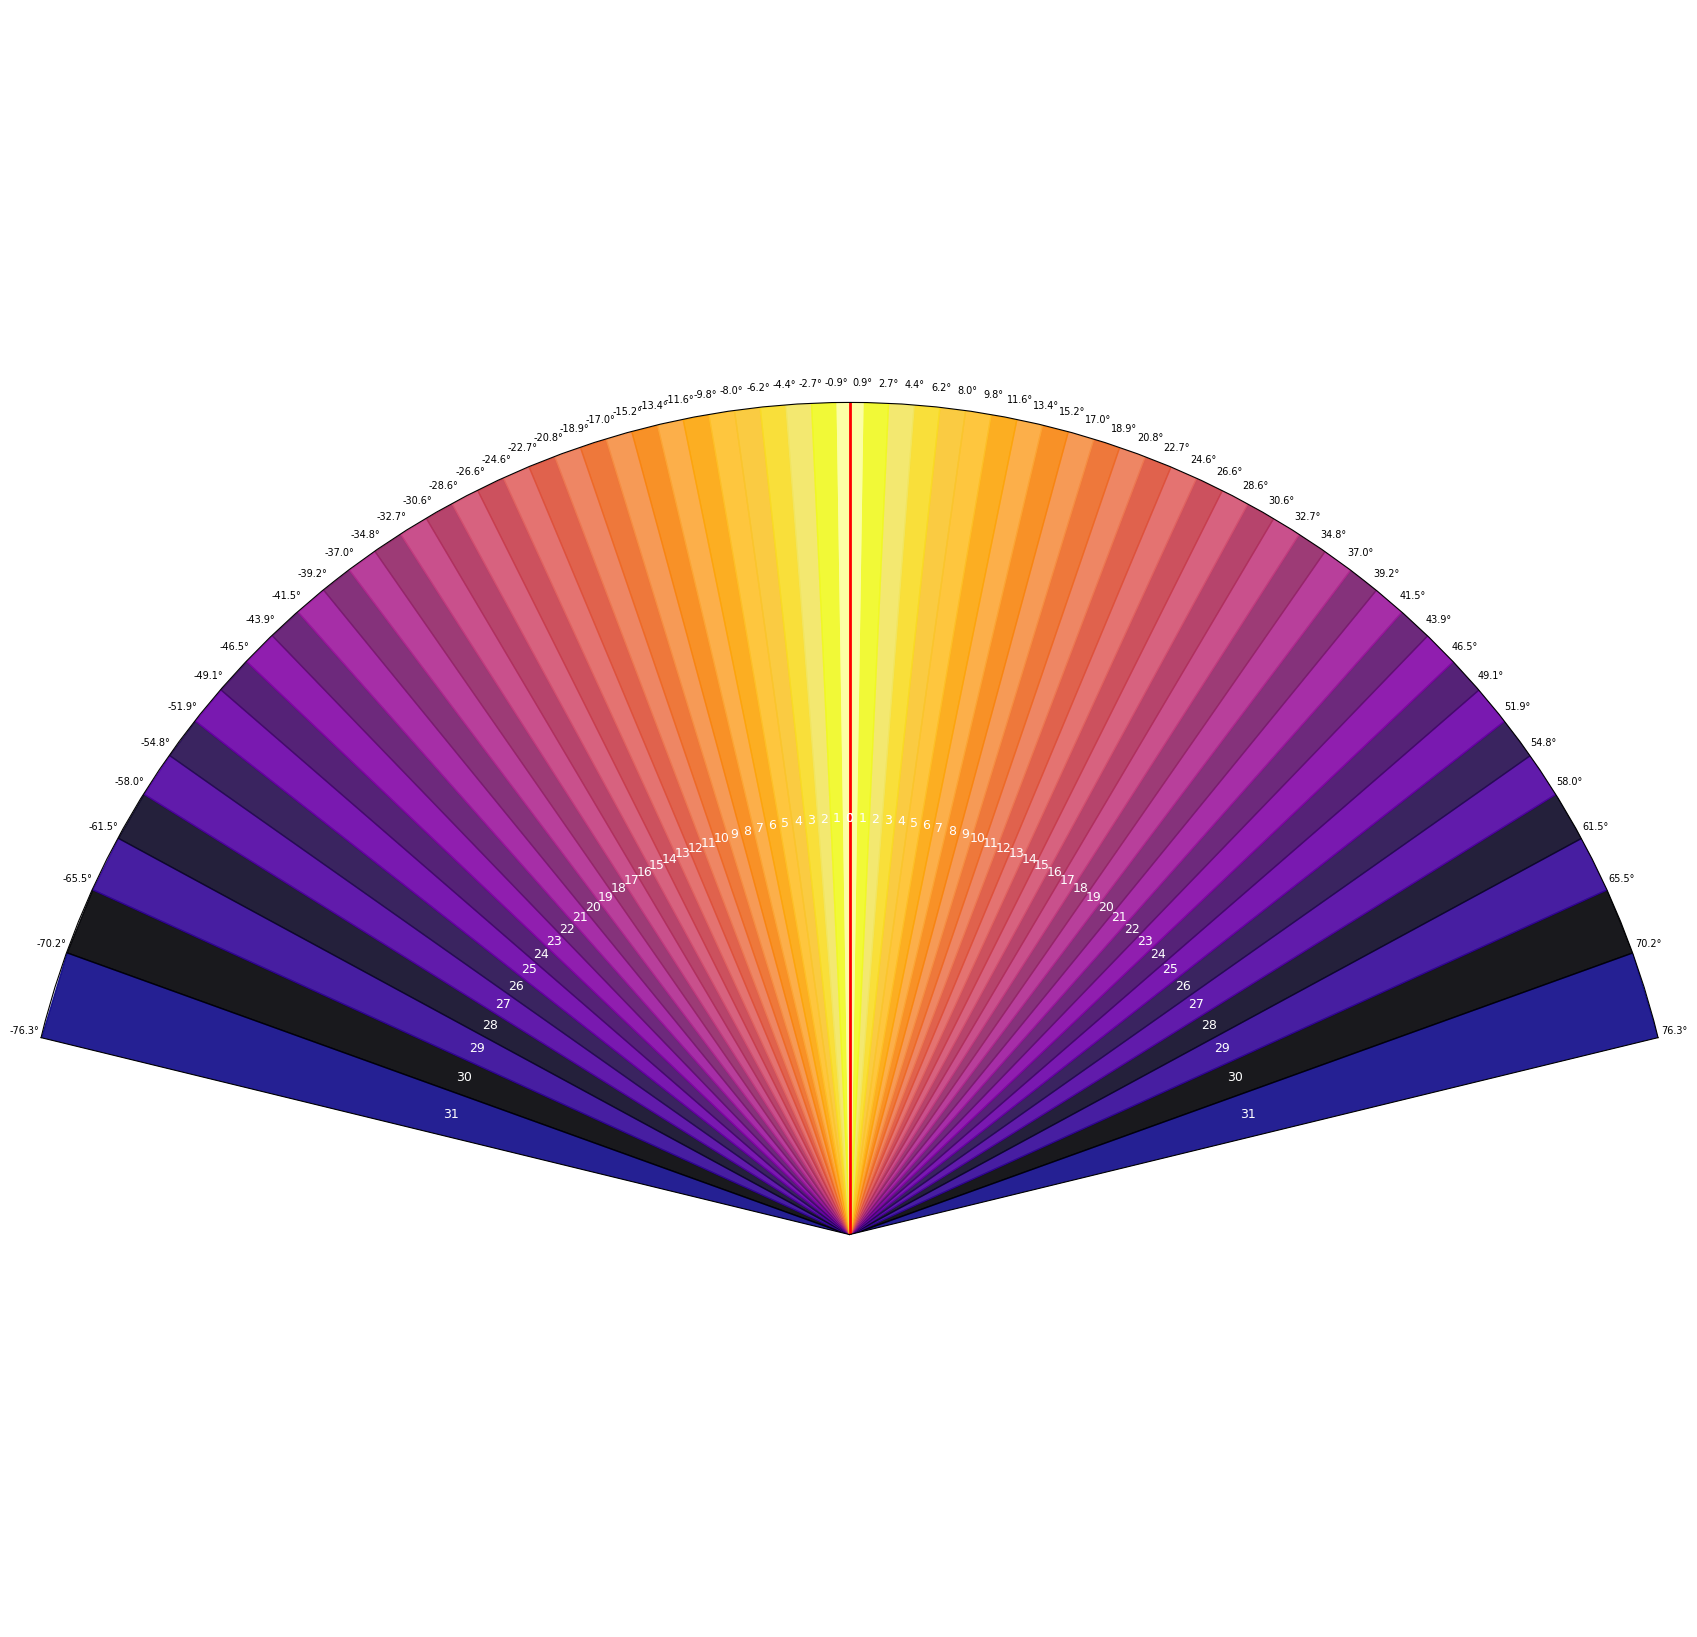

In [7]:
radar_params.display_azimuth_fov_options()

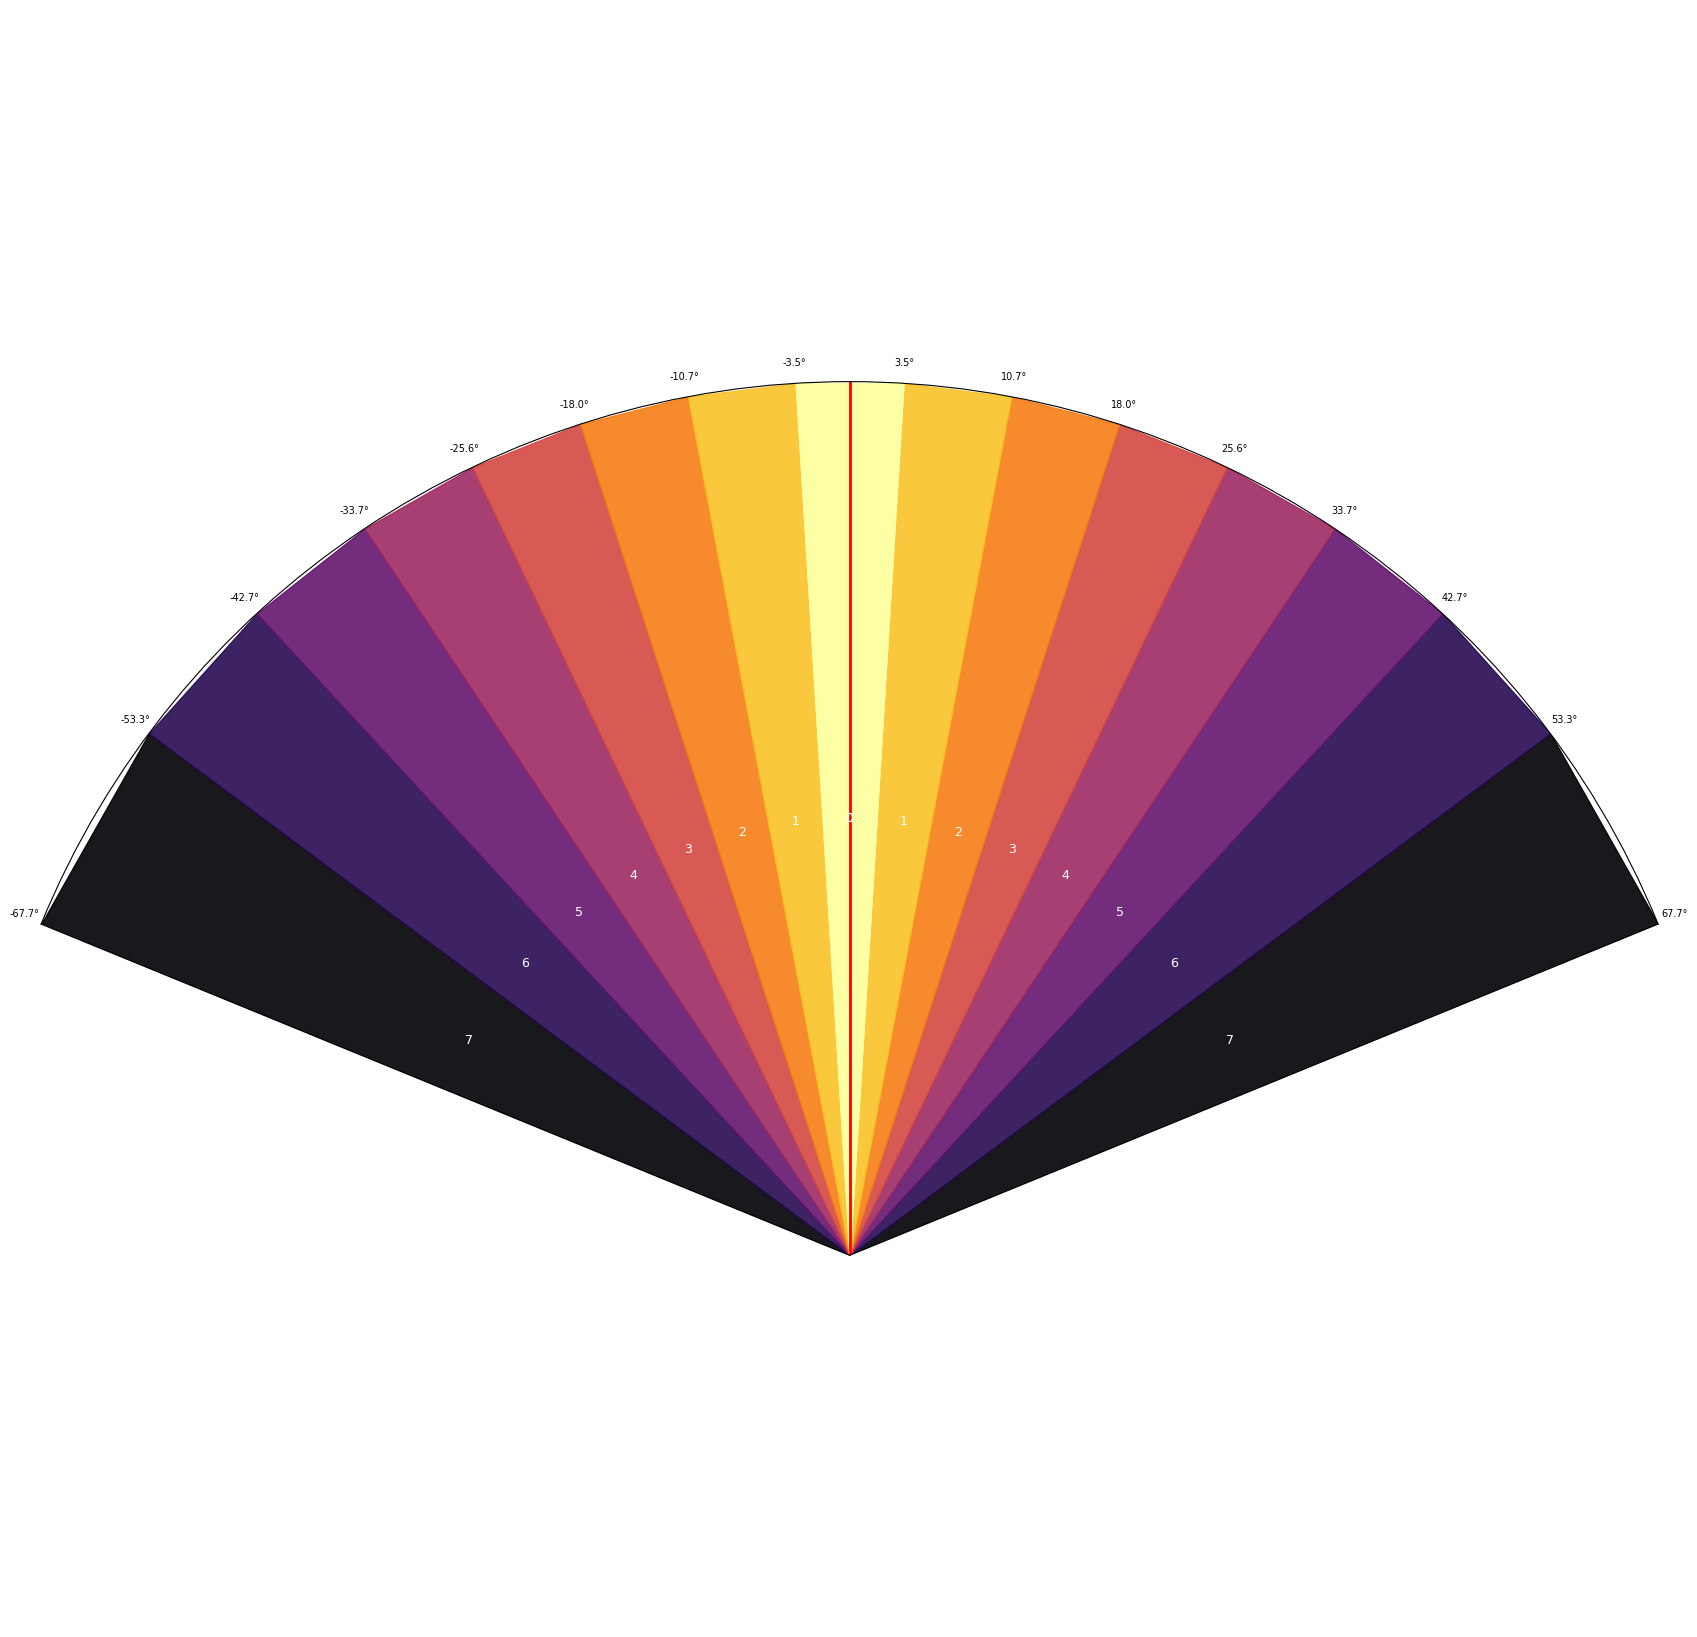

In [8]:
radar_params.display_elevation_fov_options()

### Show Cascade Radar FOV Options

In [9]:
big_radar_params = CascadeRadarParameters(COLORADAR_PATH)
big_radar_params.max_range

7.6

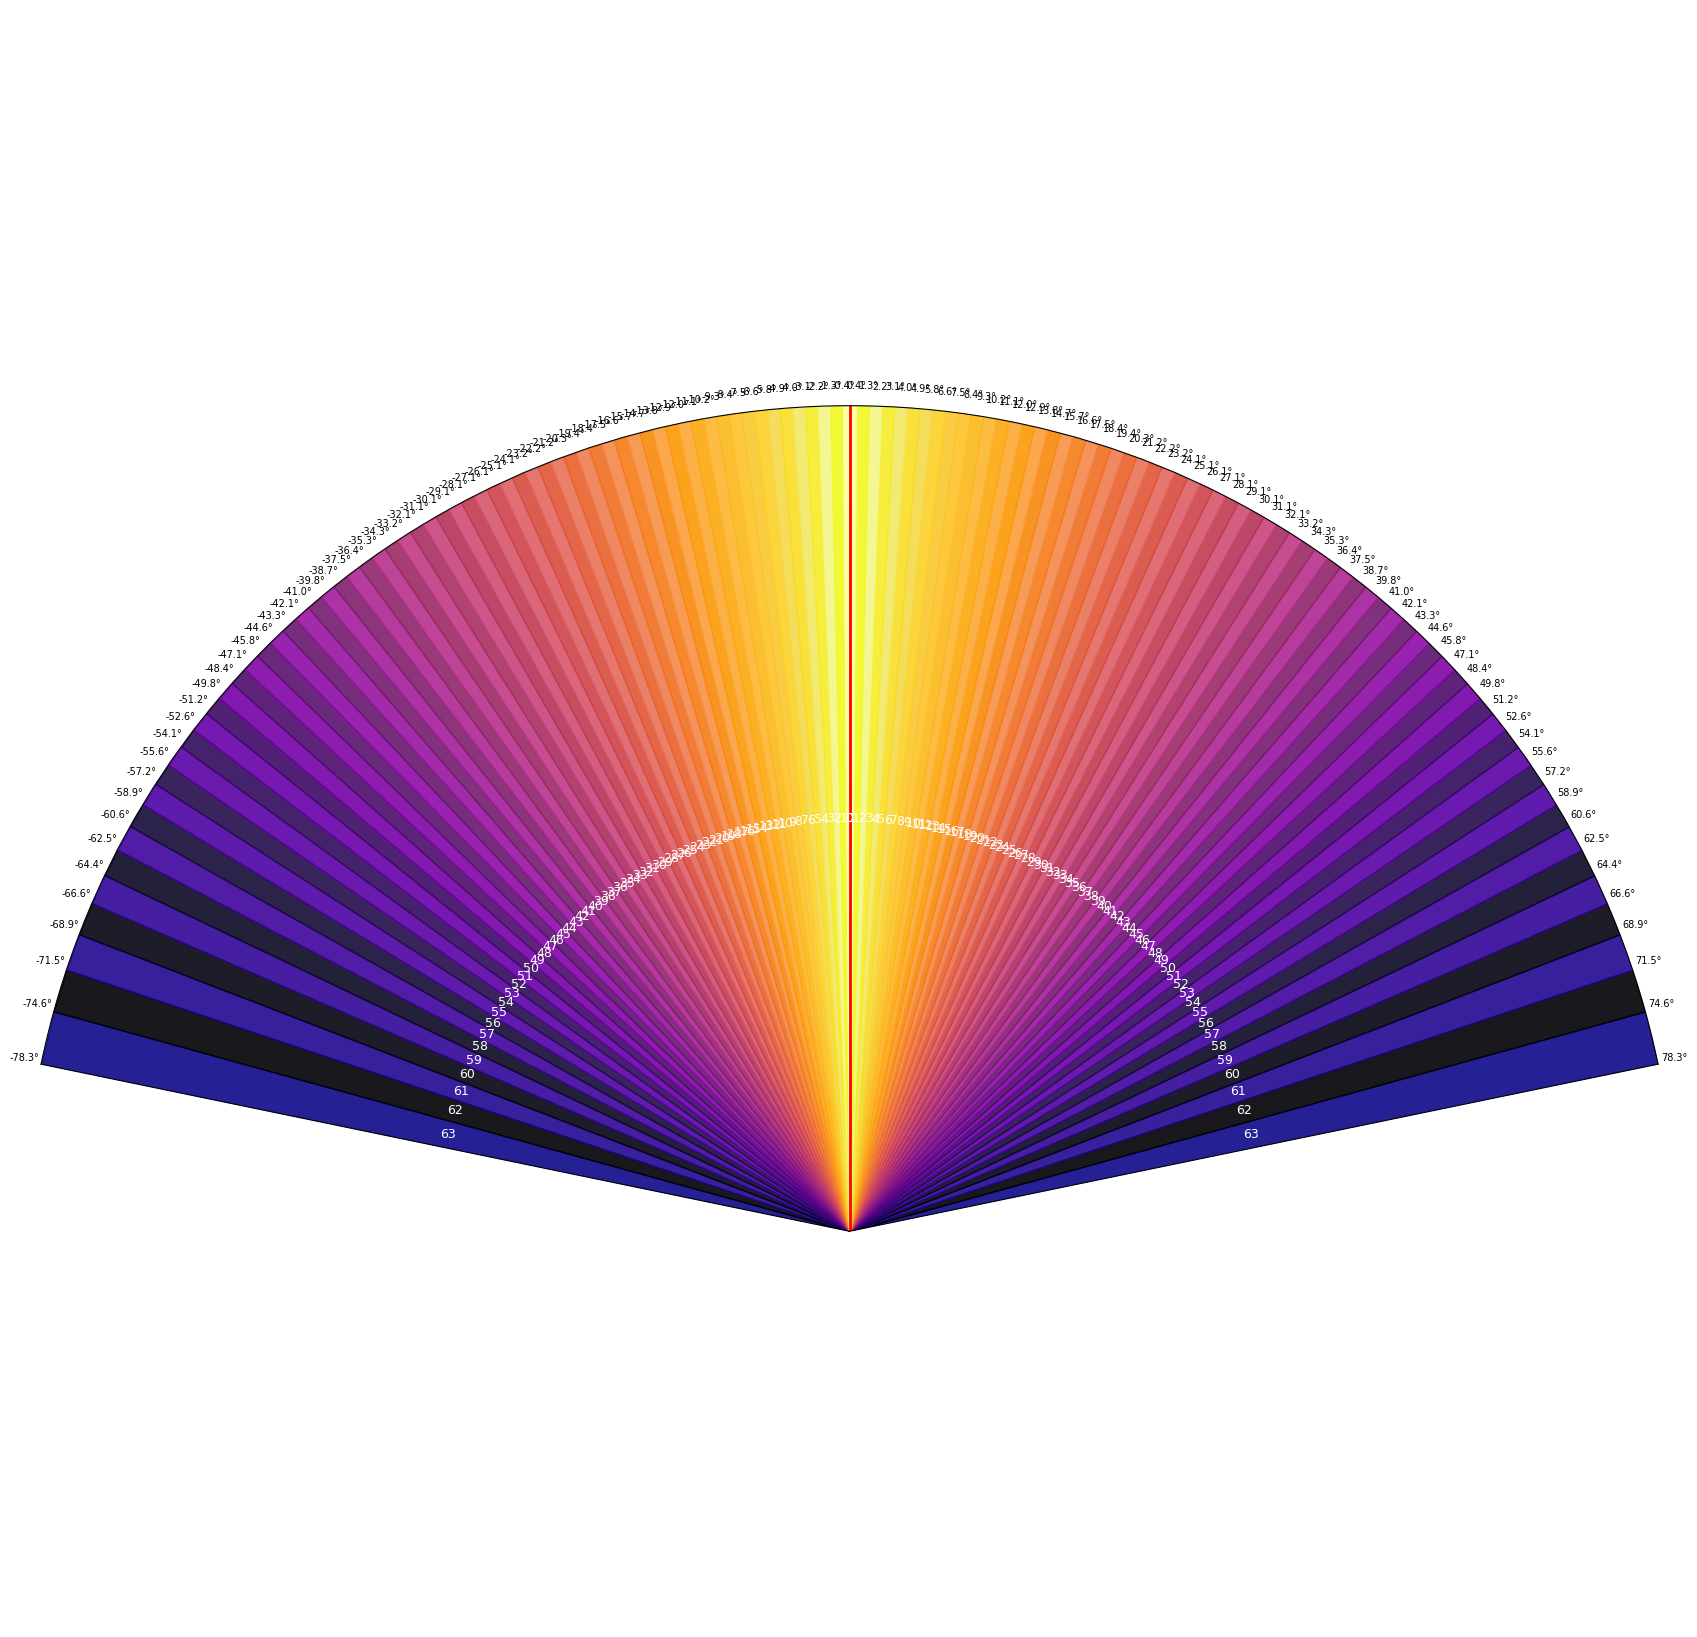

In [10]:
big_radar_params.display_azimuth_fov_options()

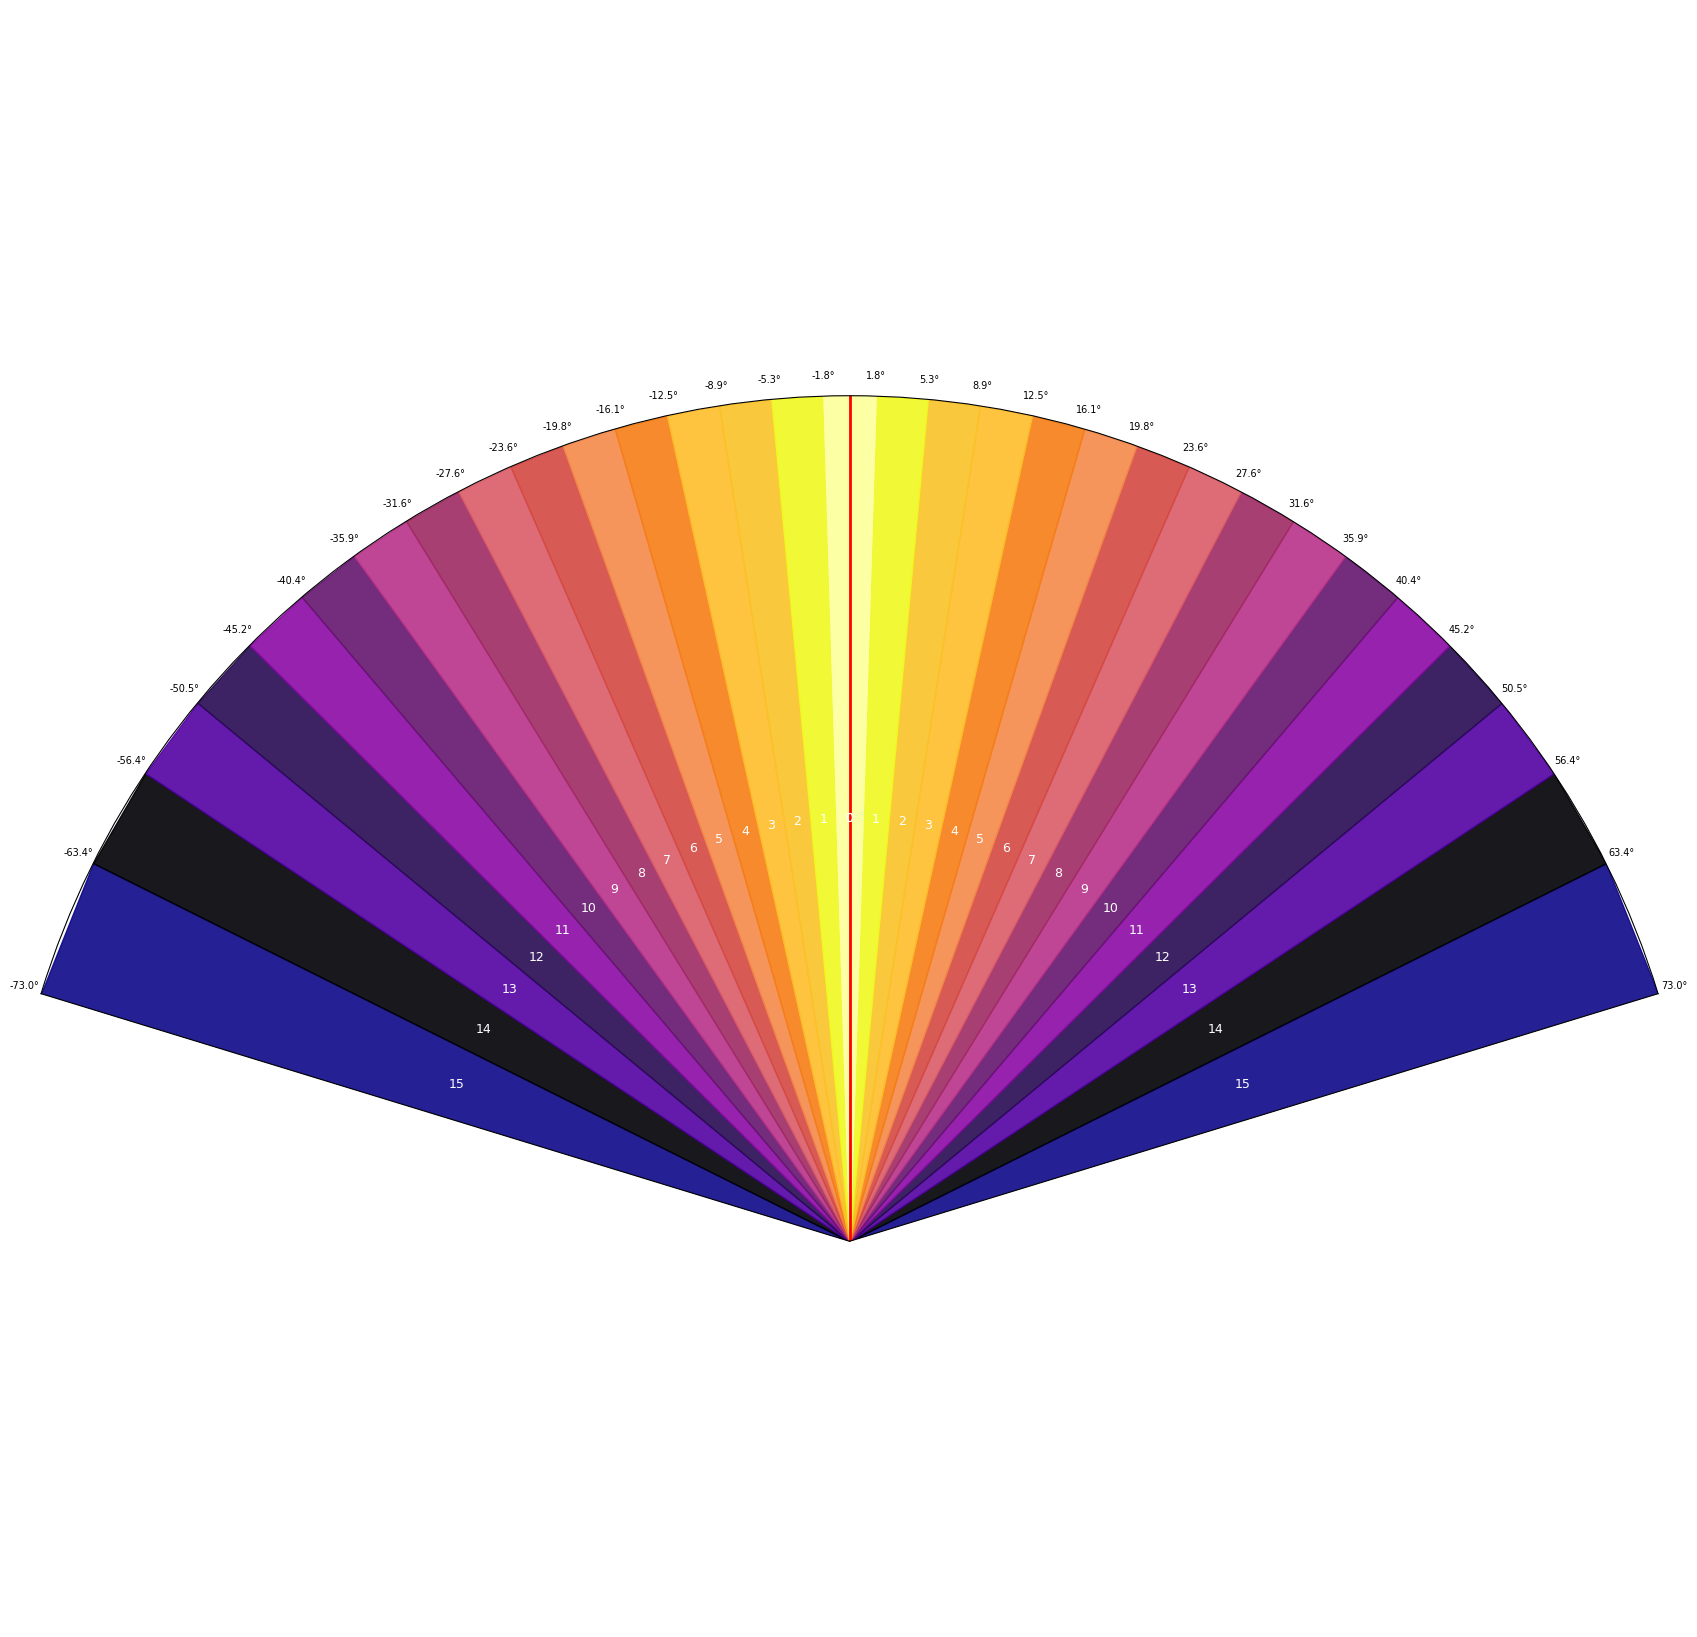

In [11]:
big_radar_params.display_elevation_fov_options()

### Sample Map in FOV

In [12]:
frame_params = big_radar_params.get_fov_parameters(azimuth_fov_idx=63, elevation_fov_idx=8, max_range_meters=7.5)
frame_params

{'horizontal_fov': 156.6, 'vertical_fov': 63.2, 'max_range': 7.5}

In [13]:
dataset.sample_map_frames(run_name, device="cascade", **frame_params)

Sampling map frames for ec_hallways_run0 ...
./build/sample_map_frames /home/arpg/coloradar ec_hallways_run0 horizontalFov=156.6 verticalFov=63.2 range=7.5 applyTransform=cascade


In [ ]:
hm = get_heatmap()

In [14]:
import struct
from pprint import pprint
hm_fname = os.path.join(COLORADAR_PATH, 'kitti', run_name, 'cascade', 'heatmaps', 'data', 'heatmap_0.bin')
with open(hm_fname, mode='rb') as file:
    frame_bytes = file.read()

frame_vals = struct.unpack(str(len(frame_bytes) // 4) + 'f', frame_bytes)
hm = np.array(frame_vals)

In [18]:
pprint(hm[:50])

array([ 2.87861548e+03,  0.00000000e+00,  6.77832520e+03,  0.00000000e+00,
        1.74536855e+04,  0.00000000e+00,  1.74620742e+04,  0.00000000e+00,
        6.67780322e+03,  0.00000000e+00,  9.70015320e+02,  0.00000000e+00,
        3.35260437e+02, -1.15275013e+00,  3.99688232e+02, -1.15275013e+00,
        3.33970154e+02,  8.23392868e-01,  2.70036713e+02,  1.64678589e-01,
        3.77714905e+02,  1.64678589e-01,  3.08834045e+02,  1.64678589e-01,
        2.76197113e+02,  3.29357177e-01,  2.95483307e+02, -1.31742871e+00,
        2.99485809e+02, -1.31742871e+00,  1.97671890e+02, -3.29357177e-01,
        3.24452972e+02, -1.31742871e+00,  3.55234528e+02,  1.15275013e+00,
        5.36979980e+02,  0.00000000e+00,  1.40526440e+03,  0.00000000e+00,
        1.18948486e+03,  0.00000000e+00,  2.59059479e+02,  0.00000000e+00,
        7.49927673e+02,  0.00000000e+00,  1.70578149e+03,  0.00000000e+00,
        1.32393652e+03,  0.00000000e+00])


In [24]:
cube_fname = os.path.join(COLORADAR_PATH, 'kitti', run_name, 'cascade', 'adc_samples', 'data', 'frame_0.bin')
with open(cube_fname, mode='rb') as file:
    frame_bytes = file.read()

frame_vals = struct.unpack(str(len(frame_bytes) // 2)+'h', frame_bytes)
cube = np.array(frame_vals, dtype=float)
# cube = frame_vals[:-1:2] + 1j * frame_vals[1::2]

In [27]:
cube[:50]

array([  69.,   95.,   93.,  320.,   89., -468.,   91., -304.,  178.,
        259.,   23.,  -67.,   79., -461.,   88.,  111.,   48.,  351.,
         73., -302.,   97., -277.,   97.,  270.,  -16.,   67.,  232.,
       -328.,  255.,  -85.,  -52.,  177., -114.,  -55.,  318.,  -32.,
        433.,  118., -179., -194., -187., -132.,  330.,  344.,  286.,
         73., -251., -338.,   24.,   84.])

(1572864,)

In [ ]:
elevation_angle = 59  # from -29.5 to 29.5, max 76.3 * 2 degrees
azimuth_angle = 118  # from -59 to 59, max 79.8 * 2 degrees
y_max = 8
map_resolution = 0.25
# x_min, x_max = -5.68, 5.68
# x_max = int(y_max * np.tan(np.radians(azimuth_angle / 2)))
# z_max = int(y_max * np.tan(np.radians(elevation_angle / 2)))
x_max = y_max * np.tan(np.radians(azimuth_angle / 2)) // map_resolution * map_resolution
z_max = y_max * np.tan(np.radians(elevation_angle / 2)) // map_resolution * map_resolution
print('x_max', x_max, 'z_max', z_max)  # 13.25m, 4.5m
azimuth_from, azimuth_to = 4, 59  # from -59.68° to 59.68°
elevation_from, elevation_to = 4, 11  # from -38° to 38°
print('Azimuth indices:', azimuth_from, ':', azimuth_to)
print('Elevation indices:', elevation_from, ':', elevation_to)



params['x_min'], params['x_max'] = -x_max, x_max
params['y_min'], params['y_max'] = 0, y_max
params['z_min'], params['z_max'] = -z_max, z_max
params['azimuth_from'], params['azimuth_to'] = azimuth_from, azimuth_to
params['elevation_from'], params['elevation_to'] = elevation_from, elevation_to
data = {'params': params}

range_bin_width = round(params['heatmap']['range_bin_width'], 3)
range_bins = np.arange(range_bin_width, y_max + range_bin_width, range_bin_width)
azimuth_bins = parse_polar_bins(params['heatmap']['azimuth_bins'])[azimuth_from:azimuth_to + 1]
elevation_bins = parse_polar_bins(params['heatmap']['elevation_bins'])[elevation_from:elevation_to + 1]

for run_folder_name in ('ec_hallways_run1',
    'arpg_lab_run0',
    'aspen_run0', 'ec_hallways_run0', 'edgar_classroom_run0',
    'longboard_run0', 'outdoors_run0'
):
    print('Processing', run_folder_name)
    map_file_path = os.path.join(coloradar_dir, run_folder_name + '_lidar_octomap_points.csv')
    run_dir = os.path.join(coloradar_dir, run_folder_name)
    poses = np.loadtxt(os.path.join(run_dir, 'groundtruth/groundtruth_poses.txt'))
    pose_timestamps = np.loadtxt(os.path.join(run_dir, 'groundtruth/timestamps.txt'))
    heatmap_timestamps = np.loadtxt(os.path.join(run_dir, 'single_chip/heatmaps/timestamps.txt'))
    pose_indices = associate_radar_with_pose(heatmap_timestamps, pose_timestamps)
    map_points = np.loadtxt(map_file_path, delimiter=',', skiprows=1)
    # print(map_points.shape)
    # print(map_points[0])
    # print('Saving total map')
    # save_total_map(map_points, poses)

    print('Calculating frames')
    map_frames = []
    poses_matched, pose_timestamps_matched = [], []
    frame_grids = []
    heatmaps = []
    for heatmap_idx, pose_idx in tqdm(enumerate(pose_indices)):
        poses_matched.append(poses[pose_idx])
        pose_timestamps_matched.append(pose_timestamps[pose_idx])

        heatmap = get_heatmap(
            filename=os.path.join(run_dir, 'single_chip/heatmaps/data/heatmap_' + str(heatmap_idx) + '.bin'),
            params=params['heatmap']
        )[elevation_from:elevation_to + 1, azimuth_from:azimuth_to + 1, :, :]
        # print(calculate_heatmap_stats(heatmap))
        heatmaps.append(heatmap)
        if heatmap_idx % 10 == 0:
            save_heatmap_image(heatmap, filename=f'heatmap_small_{heatmap_idx}.png')

        # true_points = select_points_from_pose(map_points, x_max=x_max, y_max=y_max, z_max=z_max)
        localized_points = get_localized_pointcloud(
            poses[pose_idx], map_points,
            azimuth_angle=azimuth_angle,
            elevation_angle=elevation_angle,
            y_max=y_max, z_max=z_max, x_max=x_max
        )
        frame_grid = points_to_grid(
            localized_points, resolution=map_resolution,
            x_max=x_max, y_max=y_max, z_max=z_max,
            x_min=-x_max, y_min=0, z_min=-z_max
        )
        map_frames.append(localized_points)
        frame_grids.append(frame_grid)

    polar_grids = cartesian_to_polar_grid(
        np.array(frame_grids), x_min=-x_max, x_max=x_max, y_max=y_max, z_min=-z_max, z_max=z_max,
        azimuth_bins=azimuth_bins, elevation_bins=elevation_bins, range_bins=range_bins,
        range_bin_width=range_bin_width
    )
    data[run_folder_name] = {
        'heatmaps': heatmaps,
        'gt_grids': frame_grids,
        'polar_grids': polar_grids,
        'poses': poses_matched,
        'pose_timestamps': pose_timestamps_matched
        # 'gt_points': map_frames
    }
# visualize_true_frames(map_frames, x_max=x_max, y_max=y_max, z_max=z_max)
# return
print('Heatmap shape', heatmaps[0].shape)
# print('GT frame shape', localized_points.shape)
print('GT grid shape', frame_grid.shape)

if os.path.isfile(dataset_filename):
    with open(dataset_filename, 'rb') as f:
        data_old = pickle.load(f)
else:
    data_old = {}
data_old.update(data)
print('Writing runs:', data_old.keys())
with open(dataset_filename, 'wb') as f:
    pickle.dump(data_old, f)